In [1]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import util
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import turbofan_engine.constants as const_turbofan
from ds_library.data_preprocessing.data_loader.data_loader_train_test import DataLoaderTrainTest
from ds_library.data_preprocessing.preprocessor_train_test import EspecificPreprossessorTrainTest
from ds_library.data_preprocessing.data_loader.data_loader_from_txt import DataLoaderFromTXT
from turbofan_engine.data_preprocessing.rul_calculator.calc_rul_train import CalcRULTrain
from turbofan_engine.data_preprocessing.rul_calculator.calc_rul_test import CalcRULTest
from turbofan_engine.data_preprocessing.rul_calculator.rul_config import RULConfig
from turbofan_engine.data_preprocessing.rul_calculator.rul_merge import DataFrameMerger
from turbofan_engine.data_preprocessing.rul_calculator.rul_calculator import DefaultRULCalculator
from ds_library.data_preprocessing.image.timeseries_to_image import TimeSeriesToImage
from turbofan_engine.data_preprocessing.rul_calculator.rul_filter import RULFilter, RULFilterTwo

In [2]:
FEATURES_NAME = const_turbofan.FEATURES_NAME

FEATURES_TO_REMOVE = [const_turbofan.FEATURE_UNIT_NUMBER]

TARGET = const_turbofan.TARGET

In [3]:
dataLoader = DataLoaderTrainTest(train_path=const_turbofan.RAW_PATH_FD001_TRAIN,
                                 test_path=const_turbofan.RAW_PATH_FD001_TEST,
                                 features_name=FEATURES_NAME).load_dataset()

In [4]:
X_train, X_test, y_train, y_test = EspecificPreprossessorTrainTest(
    transformers_train=Pipeline([(const_turbofan.CalcRULTrain, CalcRULTrain()),
                                 (const_turbofan.RULFilter, RULFilter())]),
    transformers_test=Pipeline([
        (const_turbofan.CalcRULTest, 
         CalcRULTest(rul_calculator=DefaultRULCalculator(),
                     merger=DataFrameMerger(),
                     df_rul=DataLoaderFromTXT(
                         path_dataset_txt=const_turbofan.RAW_PATH_FD001_RUL,
                         features_name=[const_turbofan.DEFAULT_MAX_NAME]).load_dataset(),
                     config=RULConfig(
                         feature_unit_number=const_turbofan.FEATURE_UNIT_NUMBER, 
                         feature_time=const_turbofan.FEATURE_TIME, 
                         target=const_turbofan.TARGET, 
                         default_max_name=const_turbofan.DEFAULT_MAX_NAME, 
                         total_rul=const_turbofan.TOTAL_RUL)
         )
        ),
        (const_turbofan.RULFilter, RULFilterTwo())
    ]),
    features_to_remove=FEATURES_TO_REMOVE,
    target=TARGET).preprocess(dataLoader)

In [5]:
X_train_mod = X_train.copy()
X_train_mod[TARGET] = y_train

In [6]:
X_train_new, y_train_new = TimeSeriesToImage(features_names=FEATURES_NAME[1:],
                              target=TARGET,
                              window_size=len(FEATURES_NAME[1:])).fit_transform(X_train_mod)

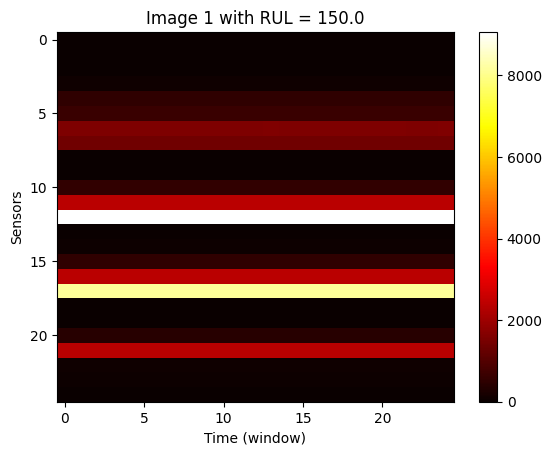

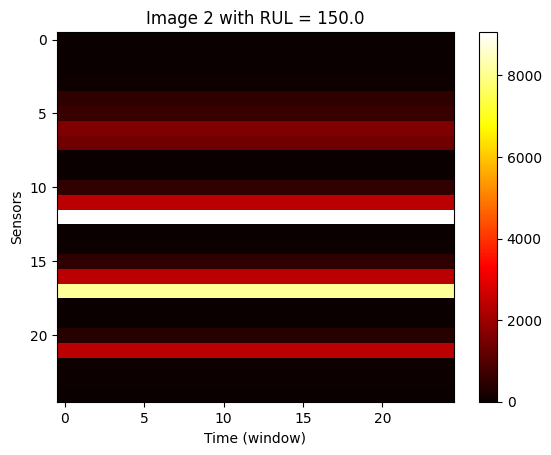

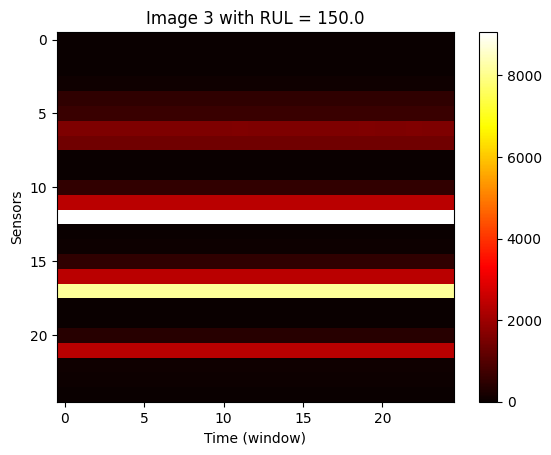

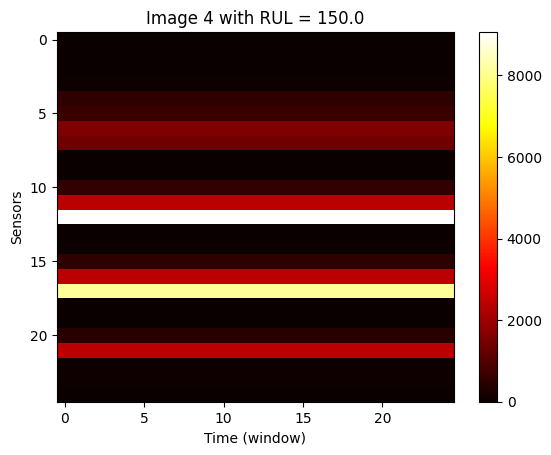

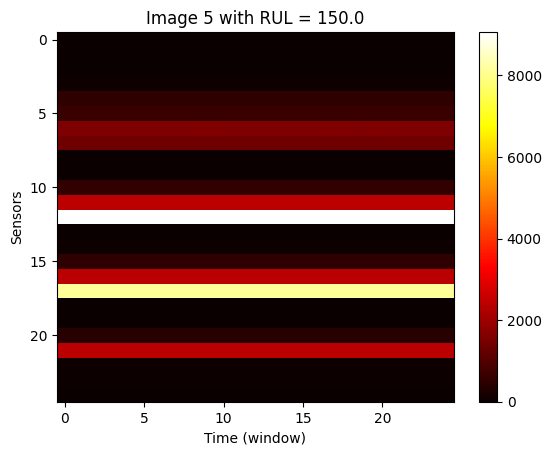

In [7]:
i = 0
for idx, (image, rul) in enumerate(zip(X_train_new, y_train_new)):
    plt.figure()
    plt.imshow(image, cmap='hot', aspect='auto')
    plt.colorbar()
    plt.title(f'Image {idx+1} with RUL = {rul}')
    plt.xlabel('Time (window)')
    plt.ylabel('Sensors')
    plt.show()
    i = i + 1
    if i == 5:
        break

In [8]:
X_train_new

array([[[ 1.00000e+00,  2.00000e+00,  3.00000e+00, ...,  2.30000e+01,
          2.40000e+01,  2.50000e+01],
        [-7.00000e-04,  1.90000e-03, -4.30000e-03, ...,  3.40000e-03,
         -1.00000e-03,  2.30000e-03],
        [-4.00000e-04, -3.00000e-04,  3.00000e-04, ..., -3.00000e-04,
          3.00000e-04, -4.00000e-04],
        ...,
        [ 1.00000e+02,  1.00000e+02,  1.00000e+02, ...,  1.00000e+02,
          1.00000e+02,  1.00000e+02],
        [ 3.90600e+01,  3.90000e+01,  3.89500e+01, ...,  3.89400e+01,
          3.90000e+01,  3.89500e+01],
        [ 2.34190e+01,  2.34236e+01,  2.33442e+01, ...,  2.34562e+01,
          2.33696e+01,  2.34288e+01]],

       [[ 2.00000e+00,  3.00000e+00,  4.00000e+00, ...,  2.40000e+01,
          2.50000e+01,  2.60000e+01],
        [ 1.90000e-03, -4.30000e-03,  7.00000e-04, ..., -1.00000e-03,
          2.30000e-03,  0.00000e+00],
        [-3.00000e-04,  3.00000e-04,  0.00000e+00, ...,  3.00000e-04,
         -4.00000e-04,  2.00000e-04],
        ...,


In [9]:
X_train_new_new, X_val, y_train_new_new, y_val = \
    train_test_split(X_train_new,
                     y_train_new,
                     test_size = 0.1,
                     stratify = None,
                     random_state = 42)

# Model

In [10]:
def create_tiled_cnn(input_shape):
    model = models.Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), 
                            padding='same', activation='relu', input_shape=input_shape))

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), 
                            padding='same', activation='relu'))

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), 
                            padding='same', activation='relu'))

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation='relu'))

    model.add(layers.Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

In [11]:
X_train.shape

(20631, 25)

In [12]:
model = create_tiled_cnn((25, 25, 1))

In [13]:
X_train_new_new

array([[[ 7.30000e+01,  7.40000e+01,  7.50000e+01, ...,  9.50000e+01,
          9.60000e+01,  9.70000e+01],
        [ 3.00000e-04, -7.00000e-04, -3.60000e-03, ..., -2.70000e-03,
          1.70000e-03, -9.00000e-04],
        [-4.00000e-04,  4.00000e-04,  4.00000e-04, ...,  1.00000e-04,
         -0.00000e+00,  3.00000e-04],
        ...,
        [ 1.00000e+02,  1.00000e+02,  1.00000e+02, ...,  1.00000e+02,
          1.00000e+02,  1.00000e+02],
        [ 3.87700e+01,  3.88200e+01,  3.89100e+01, ...,  3.87800e+01,
          3.88500e+01,  3.88400e+01],
        [ 2.32504e+01,  2.32726e+01,  2.32257e+01, ...,  2.32110e+01,
          2.32850e+01,  2.33145e+01]],

       [[ 4.00000e+00,  5.00000e+00,  6.00000e+00, ...,  2.60000e+01,
          2.70000e+01,  2.80000e+01],
        [ 1.00000e-03, -4.10000e-03, -5.00000e-04, ..., -8.00000e-04,
          3.30000e-03,  7.00000e-04],
        [-3.00000e-04,  2.00000e-04, -5.00000e-04, ...,  4.00000e-04,
         -2.00000e-04,  1.00000e-04],
        ...,


In [14]:
checkpoint_callback = ModelCheckpoint('best_model.h5', 
                                      monitor='val_mae',
                                      save_best_only=True,
                                      mode='min',
                                      verbose=1)

history = model.fit(X_train_new_new, y_train_new_new, 
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=32,
                    callbacks=[checkpoint_callback])

Epoch 1/200
580/580 [==============================] - ETA: 0s - loss: 2323.8115 - mae: 33.0125
Epoch 1: val_mae improved from inf to 24.06768, saving model to best_model.h5
580/580 [==============================] - 7s 6ms/step - loss: 2323.8115 - mae: 33.0125 - val_loss: 999.1873 - val_mae: 24.0677
Epoch 2/200
576/580 [============================>.] - ETA: 0s - loss: 1041.7778 - mae: 24.4857
Epoch 2: val_mae improved from 24.06768 to 23.61013, saving model to best_model.h5
580/580 [==============================] - 4s 7ms/step - loss: 1040.9542 - mae: 24.4647 - val_loss: 992.5228 - val_mae: 23.6101
Epoch 3/200
577/580 [============================>.] - ETA: 0s - loss: 1032.6504 - mae: 24.2502
Epoch 3: val_mae did not improve from 23.61013
580/580 [==============================] - 4s 6ms/step - loss: 1032.6095 - mae: 24.2513 - val_loss: 1036.8698 - val_mae: 24.5762
Epoch 4/200
580/580 [==============================] - ETA: 0s - loss: 1039.9431 - mae: 24.4625
Epoch 4: val_mae did no

In [15]:
X_test_mod = X_test.copy()
X_test_mod[TARGET] = y_test

X_test_new, y_test_new = TimeSeriesToImage(features_names=FEATURES_NAME[1:],
                              target=TARGET,
                              window_size=len(FEATURES_NAME[1:])).fit_transform(X_test_mod)

In [16]:
predictions = model.predict(X_test_new)

234/234 [==============================] - 1s 2ms/step


In [18]:
mean_absolute_error(y_test_new, predictions)

24.14908184534277